## Project Overview
This project focuses on the automatic estimation of parking lot occupancy using deep learning techniques. We worked with camera images of parking areas collected at the Universidade Federal do Paraná (Brazil), where individual parking spots were manually annotated through bounding boxes, originally intended for object detection tasks.
The final objective is divided into two tasks:
1. Regression task: predict the number of occupied parking spaces $n_{\text{occ}}$ in an image.
2. Binary classification task: determine whether the parking lot is mostly occupied or mostly empty, based on a threshold of 50% occupancy.

Dataset: https://public.roboflow.com/object-detection/pklot/2/preprocessing

We begin our analysis by importing all the libraries and the paths to the different splits of the dataset required throughout the project:

In [1]:
import os
import json
import glob
import copy
from collections import Counter, defaultdict

import torch
import random
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
import cv2

from sklearn.metrics import roc_curve, roc_auc_score


if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU Apple Silicon
else:
    device = torch.device("cpu")

In [2]:
train_images_root = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/train"
val_images_root   = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/valid"
test_images_root = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/test"

## Dataset format and pre-processing

#### Dataset Format
Firstly we loaded a COCO-format annotation file for our dataset and we computed the occupancy statistics. A question that may come to mind is: what is COCO?

COCO (Common Objects in Context) is a widely used dataset structure where we deal with:
1. "images"   = metadata for each image (id, filename, resolution, etc.)
2.  "annotations" = objects inside those images, each with: image_id (link to the image), category_id (class label), and bbox (bounding box around the object).

<div style="text-align: center;">
    <img src="notebook_images/coco_screen.png" width="500px">
    <p><b>Figure 1:</b> COCO data structure.</p>
</div>

#### PKLot adaption
In the Parking Lot dataset (PKLot), `category_id` field is reinterpreted to indicate parking space occupancy, where 1 corresponds to an empty space and 2 to an occupied one.

This function produces for each image:
- total number of parking spaces: $n_{\text{total}} = n_{\text{empty}} + n_{\text{occ}}$

- number of occupied and empty spaces: $\text{ratio} = \frac{n_{\text{occ}}}{n_{\text{total}}}$

- occupancy ratio: $\text{label} = \begin{cases} 1, & \text{if } \text{ratio} \ge 0.5 \\ 0, & \text{if } \text{ratio} < 0.5\end{cases}$ 

- binary label (occupied vs empty image)

- list of all bounding boxes

In [6]:

def load_coco_targets(coco_path):
    """
      Read COCO file and build:
      image_id -> {
        file_name,
        n_total,
        n_occ,
        n_empty,
        ratio_occ,
        label_binary,
        boxes
      }
    """
    with open(coco_path, "r") as f:
        coco = json.load(f)

    images = coco["images"]
    annotations = coco["annotations"]

    ann_by_image = defaultdict(list)
    for ann in annotations:
        ann_by_image[ann["image_id"]].append(ann)

    targets = {}

    for img in images:
        img_id = img["id"]
        file_name = img["file_name"]
        anns = ann_by_image[img_id]



        n_total = len(anns)
        n_empty = sum(a["category_id"] == 1 for a in anns)
        n_occ   = sum(a["category_id"] == 2 for a in anns)

        ratio = (n_occ / n_total) if n_total > 0 else 0.0
        label = 1 if ratio >= 0.5 else 0 
        targets[img_id] = {
            "file_name": file_name,
            "n_total": n_total,
            "n_occ": n_occ,
            "n_empty": n_empty,
            "ratio_occ": ratio,
            "label_binary": label,
            "anns": [
                {
                    "bbox": ann["bbox"],
                    "category": ann["category_id"]   # 1=empty, 2=occupied (PKLot COCO)
                }
                for ann in anns]

        }

    return targets

# Load COCO targets for training and validation sets

train_targets = load_coco_targets("/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/train/_annotations.coco.json")
val_targets   = load_coco_targets("/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/valid/_annotations.coco.json")
test_targets = load_coco_targets("/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/test/_annotations.coco.json")

# to visualize the structure of the first target
first_key = next(iter(train_targets))
train_targets[first_key]


{'file_name': '2013-04-10_12_00_06_jpg.rf.bef78f7879666a6d8997ce513fd8d124.jpg',
 'n_total': 40,
 'n_occ': 39,
 'n_empty': 1,
 'ratio_occ': 0.975,
 'label_binary': 1,
 'anns': [{'bbox': [304, 468, 83.5, 114], 'category': 2},
  {'bbox': [271, 390, 76.5, 89], 'category': 2},
  {'bbox': [245, 326, 67.5, 80], 'category': 2},
  {'bbox': [223, 270, 63.5, 73], 'category': 2},
  {'bbox': [204, 224, 58, 57], 'category': 2},
  {'bbox': [192, 176, 56.5, 58], 'category': 2},
  {'bbox': [171, 139, 53.5, 49], 'category': 2},
  {'bbox': [158, 101, 48.5, 50], 'category': 2},
  {'bbox': [151, 75, 46, 41], 'category': 2},
  {'bbox': [139, 46, 43, 41], 'category': 2},
  {'bbox': [365, 425, 67.5, 82], 'category': 2},
  {'bbox': [317, 353, 71, 78], 'category': 2},
  {'bbox': [302, 288, 60.5, 69.5], 'category': 2},
  {'bbox': [272, 235, 65, 62], 'category': 2},
  {'bbox': [254, 192, 61, 54], 'category': 2},
  {'bbox': [237, 148, 58, 51.5], 'category': 2},
  {'bbox': [222, 117, 49.5, 43.5], 'category': 2},
 

#### Checking for Class Imbalance

Then we examined the distribution of the binary labels derived from the occupancy ratio, defined as 
$$
\text{ratio}_{\text{occ}} = \frac{n_{\text{occ}}}{n_{\text{total}}}
$$
by applying a threshold of 0.5, which classifies each image as mostly empty or mostly occupied. This threshold-based binarization transforms a continuous measure into a meaningful majority based classification target.
To verify that class imbalance does not affect the learning process, the number of samples in each class was computed for the training, validation, and test sets. These counts were visualized using bar plots to assess the class distribution across all data splits.
The resulting histograms indicate that the two classes are reasonably balanced in all splits. As a consequence, no class imbalance mitigation strategies (such as class weighting, oversampling, or specialized loss functions) are required, and the analysis can proceed without additional corrections.

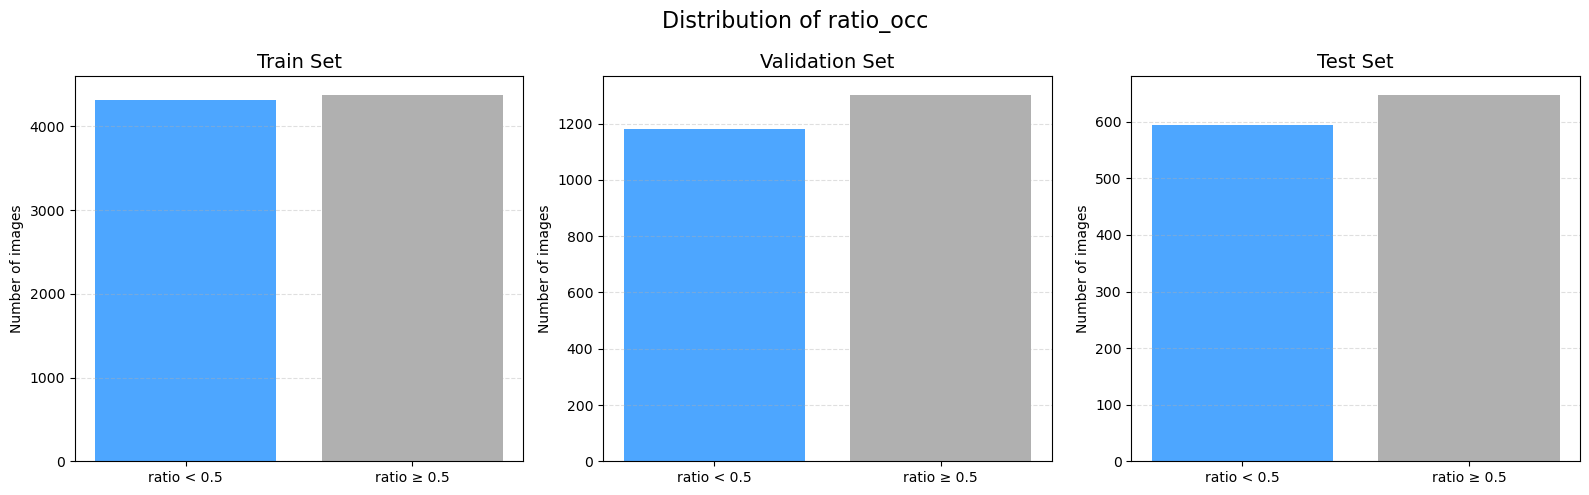

In [7]:
# ================================
#   EXTRACT GROUP COUNTS
# ================================
def count_groups(targets):
    ratios = [v["ratio_occ"] for v in targets.values()]
    G1 = sum(r < 0.5 for r in ratios)
    G2 = sum(r >= 0.5 for r in ratios)
    return G1, G2

G1_tr, G2_tr = count_groups(train_targets)
G1_v,  G2_v  = count_groups(val_targets)
G1_t,  G2_t  = count_groups(test_targets)


fig, axes = plt.subplots(1, 3, figsize=(16, 5))

datasets = ["Train", "Validation", "Test"]
counts = [(G1_tr, G2_tr), (G1_v, G2_v), (G1_t, G2_t)]

colors = ["#4DA6FF", "#B0B0B0"]  

for ax, title, (g1, g2) in zip(axes, datasets, counts):
    ax.bar(["ratio < 0.5", "ratio ≥ 0.5"], [g1, g2], color=colors)
    ax.set_title(f"{title} Set", fontsize=14)
    ax.set_ylabel("Number of images")
    ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle("Distribution of ratio_occ", fontsize=16)
plt.tight_layout()
plt.show()


#### Dataset Classes
Both dataset classes implement the PyTorch Dataset interface and are tailored to the two distinct supervised learning tasks, since although the same images are used in both cases, the tasks are treated separately because they require different target representations and learning objectives: 

Images are loaded and converted to RGB (Red Green Blue) to ensure consistent three channel inputs compatible with ResNet-18. 
Converting all images to RGB ensures that each input sample has the fixed shape:
$$x \in \mathbb{R}^{3 \times H \times W}$$
this shape is required because the first convolutional layer of ResNet-18 operates on exactly 3 input channels and $x$ represents a single input image after it has been converted to RGB and transformed into a tensor. $H$ and $W$ represents the height and the width of the image and this is the standard representation of images used in convolutional neural networks such as ResNet-18.


We will apply a set of image transformations such as resizing, color jittering, conversion to tensors and normalization. 
These transformations are defined outside the dataset classes which makes the preprocessing pipeline more flexible and easier to reproduce across different experiments. For the regression task, numerical targets are cast to float32 to align with continuous loss functions such as MSE. For the classification task, the binary label derived from a 50% occupancy threshold is encoded as a float, enabling the use of sigmoid based binary cross-entropy losses. Keeping the datasets separate and re-initializing the model between tasks prevents information from leaking from one task to the other and ensures that each model learns the correct objective.

In [8]:
class ParkingRegressionDataset(Dataset):
    """
    Task: regression (n_occ)
    """
    def __init__(self, root, targets, transform=None):
        self.root = root
        self.targets = targets
        self.transform = transform
        self.items = [(img_id, info["file_name"]) for img_id, info in targets.items()]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_id, file_name = self.items[idx]
        path = os.path.join(self.root, file_name)

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        target = torch.tensor([float(self.targets[img_id]["n_occ"])], dtype=torch.float32)

        return img, target


class ParkingClassificationDataset(Dataset):
    """
    Task: classification (label_binary)
    """
    def __init__(self, root, targets, transform=None):
        self.root = root
        self.targets = targets
        self.transform = transform
        self.items = [(img_id, info["file_name"]) for img_id, info in targets.items()]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_id, file_name = self.items[idx]
        path = os.path.join(self.root, file_name)

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(int(self.targets[img_id]["label_binary"]), dtype=torch.float32)
        return img, label

#### Transformations and Visualization
We applied a preprocessing `transform` pipeline to the training set composed of the following steps:
1. `T.Resize((256, 256))`: 
All images are resized to a fixed resolution to ensure consistent input dimensions required by CNNs. Since the task operates on whole images, resizing does not distort bounding box geometry or the semantic content necessary for counting cars. Each image is mapped to 
$$x \in \mathbb{R}^{3 \times 256 \times 256}$$

2. `T.ColorJitter(brightness=0.2, contrast=0.65, saturation=0.2, hue=0.05)`: 
Parking lots in the PKLot dataset exhibit significant variation due to:
- sunny vs. cloudy conditions
- eflections on car surfaces
- low contrast shadows
- differences in camera exposure
ColorJitter is used to model illumination variability caused by these factors: these perturbations improve robustness and reduce overfitting by encouraging invariance to color and lighting changes.

3. `T.ToTensor()`: 
this converts the PIL image in into a tensor with values in [0,1] and shape: this is required for all deep-learning operations, enabling normalization.


4. `T.Normalize(mean, sd)`: we computed the values of the mean and the standard deviation based on the statistics of our dataset. Normalization applies the following transformation:

$$\tilde{x}_{c} = \frac{x_{c} - \mu_c}{\sigma_c}$$
This operation centers each input channel and scales it to approximately unit variance. Such normalization is a standard practice in deep learning, as it improves numerical conditioning of the optimization problem (i.e., it reduces scale disparities among input features) and stabilizes gradient based training leading to faster and more reliable convergence **(LeCun et al., 1998)**.


In [9]:
stats_transform = T.Compose([
T.Resize((256, 256)),
T.ToTensor()
])

train_stats_dataset = ParkingRegressionDataset(root=train_images_root, targets=train_targets, transform=stats_transform)
stats_loader = DataLoader(train_stats_dataset, batch_size=32, shuffle=False, num_workers=0)

# mean and std for each channel (R, G, B)
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)
num_pixels = 0

for imgs, _ in stats_loader: # imgs: [B, 3, H, W]
    
    b, c, h, w = imgs.shape
    num_pixels += b * h * w
    channel_sum += imgs.sum(dim=[0, 2, 3])
    channel_sq_sum += (imgs ** 2).sum(dim=[0, 2, 3])


mean = channel_sum / num_pixels
var = channel_sq_sum / num_pixels - mean ** 2
std = torch.sqrt(var)
print("Mean per canale:", mean.tolist())
print("Std per canale:", std.tolist())


transform = T.Compose([
T.Resize((256, 256)),
T.ColorJitter(
brightness=0.2,
contrast=0.65,
saturation=0.2,
hue=0.05
),
T.ToTensor(),
T.Normalize(
mean= mean, 
std = std )
])

Mean per canale: [0.4693371653556824, 0.4737197756767273, 0.43231290578842163]
Std per canale: [0.2093743234872818, 0.2051575630903244, 0.21312697231769562]


The `show_transformed` function is a visualization utility used to inspect the effects of the preprocessing pipeline (Resize -> ColorJitter -> ToTensor -> Normalize). Its purpose is diagnostic, allowing us to verify that data augmentation does not introduce undesirable distortions and that normalization preserves sufficient contrast for the regression and classification tasks.

Since `T.ColorJitter` applies random changes to brightness, contrast, saturation, and hue, repeated executions produce different outputs, as expected. This behavior is consistent with the official PyTorch documentation:  https://docs.pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter

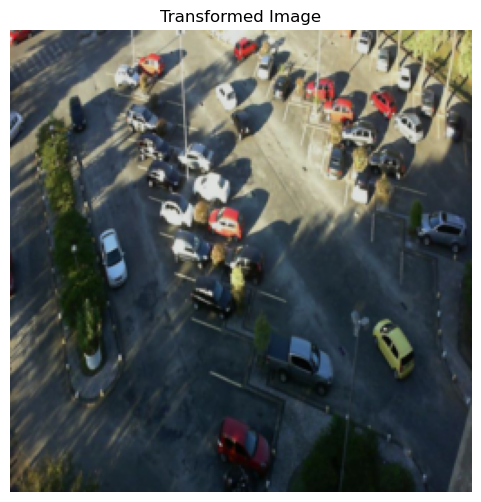

In [13]:

# ---- FUNCTION TO VISUALIZE ----
def show_transformed(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img)

    # denormalize for visualization
    mean = torch.tensor([0.4693371653556824, 0.4737197756767273, 0.43231290578842163]).view(3,1,1)
    std  = torch.tensor([0.2093743234872818, 0.2051575630903244, 0.21312697231769562]).view(3,1,1)
    img_vis = img_t * std + mean

    img_np = img_vis.permute(1,2,0).clamp(0,1).numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Transformed Image")
    plt.show()

# Example usage of show_transformed
show_transformed("/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/train/2013-03-01_17_43_00_jpg.rf.5156dec72ce62742222ed5190f646021.jpg")


## DataLoader Construction
This code block instantiates the training and validation datasets for the regression task (predicting the number of occupied parking spaces) and then wraps them in PyTorch `DataLoader` objects. Firstly we instantiate dataset objects, then we wrap them into the introduced Pytorch `DataLoader`construction, that performs two crucial functions:

1. Mini-Batching: Batches of size 32 approximate the full loss gradient
$$\nabla_{\theta} \mathcal{L}(\theta)
\approx
\frac{1}{B}
\sum_{i=1}^{B}
\nabla_{\theta} \ell(f_{\theta}(x_i), y_i)$$ 
used to approximate the full loss gradient through batches of size 32, enabling efficient stochastic gradient descent. This choice balances computational efficiency, memory usage and generalization performance. Furthermore, is motivated by empirical findings reported by Masters & Luschi (2018). While large mini-batches increase computational parallelism, they often lead to worse generalization performance and higher memory consumption. In contrast, small mini-batches introduce beneficial gradient noise, improve generalization and allow a significantly smaller memory footprint, which can also improve overall system throughput. According to these findings, the best performance is typically achieved with mini-batch sizes between $m=2$ and $m=32$ , making 32 a well-established and effective choice.

2. Shuffle: shuffling is enabled only for the training set because Stochastic Gradient Descent (SGD) relies on the assumption that each mini-batch is a random sample of the training distribution. Shuffling ensures that batches differ at every epoch, preventing the model from repeatedly seeing the same sequence of examples. This randomization reduces the risk of learning factitious correlations tied to the order of data and is part of the theoretical justification behind SGD convergence.

In contrast, the validation and test sets are used strictly for evaluation and do not participate in the optimization process. The validation loss is computed as the empirical mean

$$
\hat{\mathcal{L}}_{\text{val}}(\theta)
= \frac{1}{N}\sum_{i=1}^{N} \ell\big(f_\theta(x_i), y_i\big)
$$

which is invariant to any permutation of the validation samples. Therefore, shuffling provides no benefit for learning and has no effect on the final metric. 

More importantly, setting `shuffle=False` for validation ensures that evaluation is reproducible. With a fixed order, metrics remain stable across epochs and across runs, making debugging easier and avoiding unnecessary randomness. This is the standard practice in PyTorch official documentation.

Finally, `num_workers` controls how many CPU subprocesses are used to load and preprocess data in parallel. When `num_workers` $= 0$, all data loading happens in the main process.

In [11]:
# in order to preserve the reproducibility during validation and test:
valid_transform = T.Compose([
T.Resize((256, 256)),
T.ToTensor(),
T.Normalize(
mean= mean, 
std = std )
])

train_reg_dataset = ParkingRegressionDataset(train_images_root, train_targets, transform)
val_reg_dataset   = ParkingRegressionDataset(val_images_root, val_targets, valid_transform)
test_reg_dataset = ParkingRegressionDataset(test_images_root, test_targets, valid_transform)  

train_reg_loader = DataLoader(train_reg_dataset, batch_size=32, shuffle=True, num_workers=0) 
val_reg_loader   = DataLoader(val_reg_dataset, batch_size=32, shuffle=False, num_workers=0)
test_reg_loader = DataLoader(test_reg_dataset, batch_size=32, shuffle=False, num_workers=0)

## Custom ResNet-18 implementation
In this section we implement a custom version of ResNet-18, a residual convolutional neural network originally designed for image classification. We follow the classical ResNet design introduced by He et al. (2015), adapting the architecture to our tasks (mentioned in the **project overview**) while keeping the core residual structure unchanged.

#### BasicBlock

The BasicBlock is the core building unit of ResNet-18 and is based on the idea of residual learning. Instead of learning a full transformation of the input, the block learns a residual correction that is added to the original input through a shortcut connection. This design improves training stability by allowing gradients to flow directly through the network and mitigating vanishing gradient issues.
The block consists of two $3×3$ convolutional layers, each followed by Batch Normalization. A ReLU activation is applied only after the first convolution, while the second convolution has no activation so that the residual addition occurs before the final non linearity. The block computes:
$$y = ReLU(F(x)+S(x))$$
where $F(x)$ denotes the transformation learned by the convolutional layers and $S(x)$ represents the shortcut path.

The shortcut ensures dimensional consistency between $F(x)$ and the input (requirement of ResNet-18). When spatial resolution or channel depth changes (i.e., `stride ≠ 1` or `in_c ≠ out_c`), the shortcut is implemented as a $1×1$ convolution with appropriate stride followed by Batch Normalization; otherwise, it is an identity mapping.

During the forward pass, the block applies the two convolutions with Batch Normalization, adds the shortcut output, and finally applies a ReLU activation. This structure preserves information from earlier layers while enabling the network to learn effective feature transformations, contributing to the strong optimization and performance properties of ResNet-18.

#### ResNet18 implementation
The `ResNet18` class defines the convolutional backbone used in this project and closely follows the original ResNet-18 architecture. The network starts with a stem composed of a $7×7$ convolution with stride 2, followed by Batch Normalization, ReLU, and a $3×3$ max-pooling layer with stride 2. This stage reduces spatial resolution while extracting low-level visual features from the input RGB image.

The backbone then consists of four sequential stages (`layer1–layer4`), each composed of two BasicBlocks.
The first block of each stage may change resolution and channel depth through the stride parameter:
- `layer1`: stride 1, 64 channels;
- `layer2`, `layer3`, and `layer4`: stride 2, with channel dimensions increasing to 128, 256, and 512 respectively, while spatial resolution is halved at each stage.
This hierarchical structure allows the network to progressively learn more abstract and semantic features. Each stage is constructed using the `_make_layer` function, which handles channel transitions and stride changes in the first block, while keeping stride 1 in the remaining block. Residual connections within each block ensure stable optimization and effective gradient flow.

After the final stage, the network applies global average pooling:
$$
h = \text{AvgPool}(x) \in \mathbb{R}^{B \times 512 \times 1 \times 1}
$$
which aggregates spatial information and produces a compact feature representation independent of input image size. The pooled output is then flattened into a vector of shape $(B,512)$, which serves as the learned image embedding. This embedding is subsequently used by the regression head for car counting and, after fine-tuning, by the classification head for occupancy prediction.

#### Regression and Classification heads
In our architecture, both the regression and classification models share the same ResNet-18 backbone, whose role is to map each input image to a compact feature representation $h ∈ R^{512}$ . The backbone is trained during the regression phase and learns general visual features of parking lot images. Once trained, it acts as a reusable feature extractor for the 2 tasks we need to perform.

1. For the regression task, a simple linear head is attached to the backbone. Given the feature vector h, the predicted number of occupied parking spaces is computed as:
$$\hat{y} = W_{\text{reg}}\, h + b_{\text{reg}}$$
which yields an output $\hat{y} ∈ R$ . This minimal design is sufficient for continuous prediction, aligns with classical regression theory, and reduces the risk of overfitting when used with losses such as MSE.

2. After training the regression model, the backbone is reused for the binary classification task, following a transfer learning approach. The assumption is that features useful for counting occupied spaces are also informative for deciding whether occupancy exceeds the 50% threshold. For this reason in this second task, only the classification head is trained from scratch while the backbone has beem kept frozen. The classification head consists of a small multilayer perceptron: a first linear layer reduces the 512 dimensional feature vector to 128 units, followed by ReLU activation and dropout to improve generalization and a second linear layer maps from 128 to 1 output unit. This last unit does not apply a sigmoid, because for numerical stability we use BCEWithLogitsLoss, which expects a raw logit. The head maps the backbone features to a single output logit:
$$z=g(h)$$
where $z ∈ R$. The corresponding probability can be obtained via the sigmoid function
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [12]:

class BasicBlock(nn.Module):
    expansion = 1 # because in larger ResNet models (ResNet-50, ResNet-101, ResNet-152) each block uses a bottleneck architecture in which the final number of channels is out_channels_final = out_channels*expansion.
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)

        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        y = torch.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y = y + self.shortcut(x) 
        return torch.relu(y)


class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_c = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(True)
        self.maxp  = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64,  2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def _make_layer(self, out_c, blocks, stride):
        layers = [BasicBlock(self.in_c, out_c, stride)]
        self.in_c = out_c
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxp(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        return torch.flatten(x, 1)  # (B, 512)


class ResNetRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ResNet18()
        self.head = nn.Linear(512, 1)

    def forward(self, x):
        h = self.backbone(x)
        y = self.head(h) 
        return y   # (B,1) — CORRETTO


class ResNetClassification(nn.Module):
    def __init__(self, trained_backbone):
        super().__init__()
        self.backbone = trained_backbone

        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        h = self.backbone(x)
        logits = self.head(h)
        return logits.squeeze(1)   # needed for BCEWithLogitsLoss


## Loss functions
In this project we use two different loss functions: 

1. Regression task:
$$\mathcal{L}_{\text{MSE}}(\hat{y}, y) 
= \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2$$

MSE is the standard choice for regression because:
- it is convex and differentiable,
- it produces smooth gradients,
- it heavily penalizes larger errors, encouraging precise predictions.


2. Binary classification task: the model outputs a logit $z$ a real number that is not yet passed through a sigmoid.
Using logits directly is numerically more stable, so PyTorch provides the combined operation Binary Cross Entropy With Logits.
The theoretical binary cross-entropy loss is:
$$
\mathcal{L}_{\text{BCE}}(z, y)
= - \left[ y \, \log(\sigma(z)) + (1-y)\log(1-\sigma(z)) \right]
$$
where the sigmoid converts logits to probabilities:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [13]:
def regression_loss(pred, target):
    return F.mse_loss(pred, target)

def classification_loss(logits, target):
    return F.binary_cross_entropy_with_logits(logits, target)

## Learning Rate Finder
Before training our ResNet-18 for regression, we used a Learning Rate Finder (LR Finder) to identify a good learning rate for the optimizer.
This technique, originally introduced by Leslie Smith (2017), allows us to choose a learning rate that leads to fast convergence while avoiding values that make the loss unstable or divergent.

#### How does it work?
Instead of training the model normally, the LR Finder performs a range test:
1. We start with a very small learning rate: $l_{start} = 10^{-4}$
2. Increase the learning rate exponentially using a scheduler over a predefined number of iterations (in our case, 700). For each iteration $i$, the learning rate is:

$$\text{lr}(i) = \text{lr}_{\text{start}} \left( \frac{\text{lr}_{\text{end}}}{\text{lr}_{\text{start}}} \right)^{\frac{i}{N}}$$
where $lr_{end}=0.1$ is the maximum rate tested and $N=num_{iter}=700$ is the number of iterations.

3. For every batch we run firstly one forward and backward pass, then we record the current loss and then smooth the loss using exponential smoothing.

4. Stop if the loss diverges

5. Restore the original weights such that we ensure that no learning happens during test.


In [14]:

# ========================================
# LR FINDER
# ========================================
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
        # save initial weights of the model
        torch.save(self.model.state_dict(), "init_params.pt")

    def range_test(self, iterator, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)

        
        for iteration in range(num_iter):
            loss = self._train_batch(iterator)
            # update of the learning rate 
            lr_scheduler.step()
            lrs.append(lr_scheduler.get_lr()[0])
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            
            if loss < best_loss:
                best_loss = loss
                losses.append(loss)
            
            # stop if it diverges 
            if loss > diverge_th * best_loss:
                print("Stopping early: loss diverged")
                break
   
        self.model.load_state_dict(torch.load("init_params.pt", map_location=self.device))
        return lrs, losses
        
    def _train_batch(self, iterator):
        
        self.model.train()
        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()

        return loss.item()

# ========================================
# EXPONENTIAL SCHEDULER
# ========================================
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super().__init__(optimizer, last_epoch)
    
    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

# ========================================
# ITERATOR WRAPPER
# ========================================
class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)
    
    def __next__(self):
        try:

            x, y = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            x, y = next(self._iterator)
        return x, y
    
    def get_batch(self):
        return next(self)
    
def plot_lr_finder(lrs, losses, skip_start, skip_end):

    min_len = min(len(lrs), len(losses))
    lrs = lrs[:min_len]
    losses = losses[:min_len]

    if skip_end > 0:
        lrs_plot = lrs[skip_start:-skip_end]
        losses_plot = losses[skip_start:-skip_end]
    else:
        lrs_plot = lrs[skip_start:]
        losses_plot = losses[skip_start:]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(lrs_plot, losses_plot)
    ax.set_xscale("log")
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Loss")
    ax.set_title("LR Finder")
    ax.grid(True, which ="both", axis="both")
    plt.show()


The loss vs learning rate plot clearly shows that very small learning rates lead to slow convergence, excessively large values cause instability and only an intermediate range yields a steep loss decrease; based on this behavior, the learning rate $10^{-3}$ was identified as the most suitable choice for our analysis.

Notice that as weights initialization we applied the same function used in the training weights initialization.

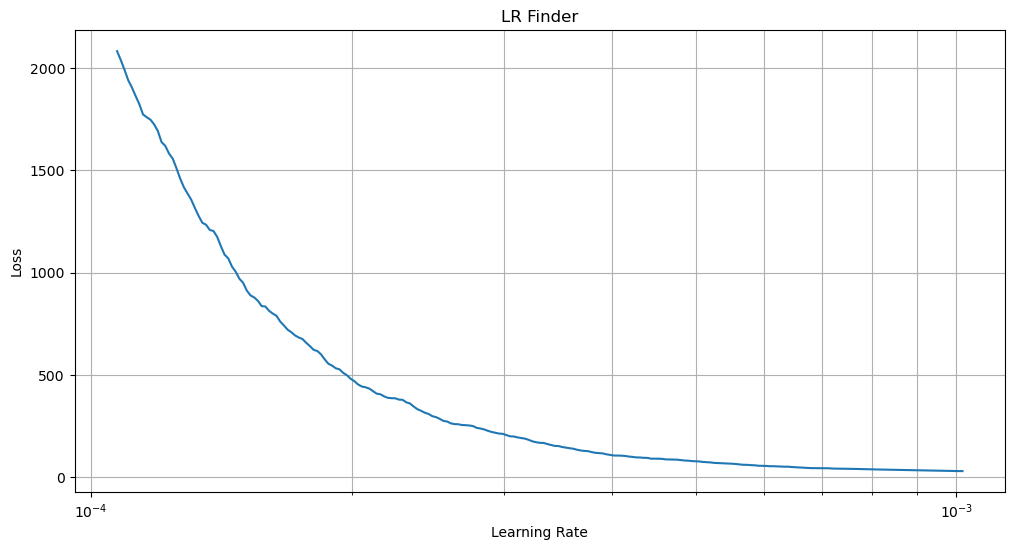

In [ ]:
END_LR = 0.1
NUM_ITER = 700

START_LR = 1e-4

# ======================================
#   WEIGHTS INITIALIZATION FUNCTION
# ======================================
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias) 
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model = ResNetRegression()

optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.MSELoss()

model.apply(init_weights)
model = model.to(device)
criterion = criterion.to(device)

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_reg_loader, end_lr=END_LR, num_iter=NUM_ITER)



plot_lr_finder(lrs, losses, skip_start=5, skip_end=0)

## Training Loop: Regression

In [20]:

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, fmts=('-', '--'), figsize=(6, 4)):
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend
        self.fmts = fmts
        self.x, self.y = [], []
        self.xlim = xlim
        self.ylim = ylim
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        if legend:
            self.ax.legend(legend)
        display.display(self.fig)

    def add(self, x, ys):
        if not isinstance(ys, (list, tuple)):
            ys = [ys]
        if len(self.y) == 0:
            for _ in ys:
                self.y.append([])
        self.x.append(x)
        for i, y in enumerate(ys):
            self.y[i].append(y)

        self.ax.cla()
        for i, (y, fmt) in enumerate(zip(self.y, self.fmts)):
            self.ax.plot(self.x, y, fmt, label=self.legend[i] if self.legend else None)

        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel(self.ylabel)

        if self.legend:
            self.ax.legend(self.legend)

        if self.xlim:
            self.ax.set_xlim(self.xlim)
        if self.ylim:
            self.ax.set_ylim(self.ylim)

        display.clear_output(wait=True)
        display.display(self.fig)


#### Weight inizialition
All convolutional and fully connected layers are explicitly initialized using Kaiming (He) initialization, which is theoretically consistent with ReLU activations and helps preserve variance propagation across deep networks. This choice reduces the risk of vanishing or exploding gradients and is particularly important when training the model from scratch without relying on pre-trained weights. Biases in the linear layers are initialized to zero to avoid introducing an artificial offset in the regression head, which could otherwise lead to unstable predictions during the early stages of training.

#### Optimizer and Scheduler
Optimization is carried out using the Adam optimizer, which adapts the learning rate on a per parameter basis and is well suited for deep convolutional regression tasks where gradient magnitudes may differ significantly across layers. The learning rate policy combines two complementary strategies: an initial linear warm up phase, during which the learning rate is gradually increased from 10% to its nominal value to stabilize early training dynamics, followed by a cosine annealing schedule that progressively decreases the learning rate. This design allows for stable convergence in the early epochs while enabling finer parameter updates as training progresses.

#### Training and Validation loop
The training and validation phases are clearly separated by switching the model between `train()` and `eval()` modes. During validation, gradient computation is disabled using `torch.no_grad()`, ensuring that model parameters are not updated and reducing memory consumption. The loss is accumulated proportionally to the batch size and normalized by the total number of samples, yielding an unbiased estimate of the empirical risk over both the training and validation datasets.

#### Early stopping and model selection 
Finally, an early stopping mechanism based on the validation loss is employed with a fixed patience. The model parameters corresponding to the lowest observed validation loss are stored and restored at the end of training, ensuring that the final selected model reflects the best generalization performance achieved during training rather than the parameters from the final epoch.

In [21]:

# ======================================
#   WEIGHTS INITIALIZATION FUNCTION
# ======================================
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias) 
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


def train_regression(model, train_loader, val_loader, device,
                     epochs=30, lr=1e-4, patience=8, warmup_epochs=3,
                     save_dir="best_models", save_name="best_model.pth"):
    
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, save_name)
    
    # -----------------------
    #  INIT MODEL + WEIGHTS
    # -----------------------
    model.apply(init_weights)
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # -----------------------------
    #   SCHEDULER + WARMUP
    # -----------------------------
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt,
        T_max=epochs - warmup_epochs,
        eta_min=lr * 0.1
    )

    def get_warmup_lr(epoch):
        """Linear: starts from 10%lr and arrives to lr."""
        warmup_start = lr * 0.1
        return warmup_start + (lr - warmup_start) * (epoch / warmup_epochs)

    # --------- EARLY STOPPING ---------
    best_val_loss = float("inf")
    best_model_state = None
    counter = 0

    train_losses = []
    val_losses = []

    # ===============================
    #   ANIMATOR FOR LIVE PLOTTING
    # ===============================
    animator = Animator(
        xlabel='epoch',
        ylabel='loss',
        xlim=[1, epochs],
        legend=['train', 'val']
    )

    print("Starting training...")
    for epoch in range(1, epochs+1):

        # ------------------------
        # WARMUP LOGIC
        # ------------------------
        if epoch <= warmup_epochs:
            current_lr = get_warmup_lr(epoch)
            for param_group in opt.param_groups:
                param_group['lr'] = current_lr
        else:
            scheduler.step()
            current_lr = opt.param_groups[0]['lr']

        # -------------------------
        # TRAIN MODE
        # -------------------------
        model.train()
        train_loss = 0.0
        n = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            preds = model(x)
            loss = regression_loss(preds, y)
            loss.backward()
            opt.step()

            train_loss += loss.item() * x.size(0)
            n += x.size(0)

        train_loss /= n
        train_losses.append(train_loss)

        # -------------------------
        # VALIDATION MODE
        # -------------------------
        model.eval()
        val_loss = 0.0
        m = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = regression_loss(preds, y)

                val_loss += loss.item() * x.size(0)

                m += x.size(0)

        val_loss /= m
        val_losses.append(val_loss)

        # -------------------------
        # EARLY STOPPING
        # -------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, save_path)
            print(f"Saved new best model at epoch {epoch} | Val loss: {val_loss:.4f}")

        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # -------------------------
        # UPDATE ANIMATOR
        # -------------------------
        animator.add(epoch, [train_loss, val_loss])

        print(f"[REG] Epoch {epoch}/{epochs} | "
              f"Train: {train_loss:.4f} | "
              f"Val: {val_loss:.4f} | ")
        
    # ======================================================
    # RESTORATION OF THE BEST MODEL
    # ======================================================
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model with val loss = {best_val_loss:.4f}")


    return model, train_losses, val_losses



#### Interpretation of the Animator: Regression
The loss curves show a rapid decrease in both training and validation loss during the first few epochs, followed by stabilization close to zero after approximately $11$ epochs. Throughout training, the two curves remain closely aligned, indicating that the model learns a meaningful mapping from input images to parking occupancy counts while exhibiting limited overfitting. The early plateau suggests that the model reaches its effective capacity relatively quickly for this dataset and the smooth, non oscillatory behavior of the curves confirms the effectiveness of the warm up and cosine annealing learning rate schedule.

The training output further support this interpretation: the best validation loss is approximately $0.7352$, while the final training loss is around $0.2$. This gap indicates that the model fits the training data well, with a small but non zero generalization error, which is expected in a regression setting affected by visual ambiguity and inherent annotation noise.

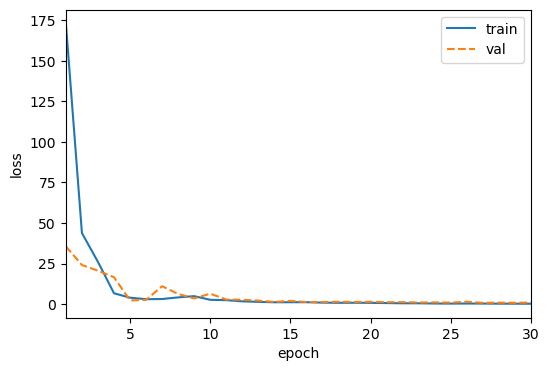

[REG] Epoch 30/30 | Train: 0.2000 | Val: 0.9295 | 
Restored best model with val loss = 0.7352


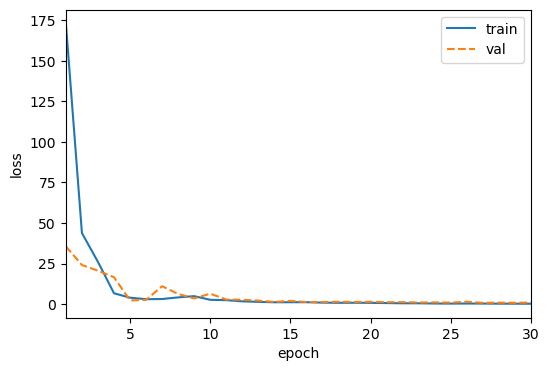

In [22]:
print(device)

reg_model = ResNetRegression()

trained_reg_model = train_regression(
    reg_model,
    train_reg_loader,
    val_reg_loader,
    device,
    epochs=30,
    lr=1e-3, 
    patience=8,
    warmup_epochs=3,
    save_dir="Checkpoints",
    save_name="Parking_Reg_count.pth"
)

In [23]:
def load_model(model, path, device):

    state_dict = torch.load(path, map_location=device)

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  

    print(f"Model loaded from: {path}")
    return model

In [24]:
best_model = ResNetRegression()
best_model = load_model(best_model, "Checkpoints/Parking_Reg_count.pth", device)
best_model

Model loaded from: Checkpoints/Parking_Reg_count.pth


ResNetRegression(
  (backbone): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxp): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Test phase evaluation: Regression
The regression model is evaluated on a held-out test set using `model.eval()` and `torch.no_grad()`, ensuring that:
- no gradients are computed,
- batch normalization layers operate in inference mode,
- results reflect true generalization performance.
Images with $n_{total}$ = 0 are explicitly excluded from evaluation. This avoids division by zero issues in relative metrics and ensures that all reported errors correspond to valid parking scenarios.

In [25]:

def test_regression(model, test_loader, device, targets):
    model.eval()
    
    mse_loss = 0
    mae_loss = 0
    roe_loss = 0
    skipped = 0
    n = 0

    loader_with_index = enumerate(test_loader)

    with torch.no_grad():
        for idx, (x, y) in loader_with_index:
           
            img_id = test_loader.dataset.items[idx][0]
            n_total = targets[img_id]["n_total"]

            # Skip images with n_total = 0
            if n_total == 0:
                skipped += 1
                continue

            x = x.to(device)
            y = y.to(device)
            n_total = torch.tensor([n_total], dtype=torch.float32).to(device)

            preds = model(x)

            # MSE, MAE
            mse_loss += F.mse_loss(preds, y, reduction="sum").item()
            mae_loss += torch.abs(preds - y).sum().item()

            # ROE
            roe_loss += (torch.abs(preds - y) / n_total).sum().item()

            n += x.size(0)

    mse = mse_loss / n
    rmse = mse ** 0.5
    mae = mae_loss / n
    roe = roe_loss / n

    print("\n[TEST RESULTS]")
    print(f" Skipped images (n_total=0): {skipped}")
    print(f" MSE  = {mse:.4f}")
    print(f" RMSE = {rmse:.4f}")
    print(f" MAE  = {mae:.4f}")
    print(f" ROE  = {roe:.4f}")

    return mse, rmse, mae, roe



#### Evaluation metrics
We computed different absolute measures such as:
1. $MSE$: lower to 1 indicates that the model generalizes well.
2. $RMSE$: lower to 1 suggests that larger errors are rare and limited in magnitude.
3. $MAE: 0.49$ indicates that, on average, the predicted parking count differs from the ground truth by approximately half a parking spot.

but also a relative one, the ROE (Relative Occupancy Error):
$$
\mathrm{ROE} = \frac{\left| \hat{y} - y \right|}{n_{\text{total}}}
$$
almost 1% shows that the relative error scales well with parking size, remaining small even for large parking lots.

Images with $n_{total}$ = 0  are explicitly skipped because the Relative Occupancy Error (ROE) involves a division by the total number of parking slots, which would be undefined in this case and would artificially inflate the error metrics. In our specific setting, this exclusion does not represent a limitation: by inspecting the corresponding image IDs, we verified that these cases correspond to completely empty parking lots with no occupied slots, for which the model predictions were already correct. Therefore, skipping these samples prevents numerical issues without introducing bias or affecting the validity of the evaluation.

In [26]:
mse, rmse, mae, roe = test_regression(
    best_model,
    test_reg_loader,
    device, 
    test_targets
)


[TEST RESULTS]
 Skipped images (n_total=0): 2
 MSE  = 0.8203
 RMSE = 0.9057
 MAE  = 0.4933
 ROE  = 0.0096


Then we proceeded our analysis with a plot that could help us in visualizing the predicted values vs the true ones:

In [27]:

def plot_pred_vs_true(model, test_loader, device):
    model.eval()
    
    all_preds = []
    all_truth = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x)

            all_preds.append(preds.cpu().numpy())
            all_truth.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_truth = np.concatenate(all_truth).flatten()

    # -----------------------------
    # PLOT
    # -----------------------------
    plt.figure(figsize=(7,7))
    plt.scatter(all_truth, all_preds, alpha=0.6, label="Predictions")
   
    min_v = min(all_truth.min(), all_preds.min())
    max_v = max(all_truth.max(), all_preds.max())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--', label="Ideal y = x")

    plt.xlabel("True Count (n_occ)")
    plt.ylabel("Predicted Count")
    plt.title("Predicted vs True — Regression Model")
    plt.legend()
    plt.grid(True)
    plt.show()

    return all_truth, all_preds


#### Visualization of the predicted values vs true ones
The majority of points lie close to the ideal line $y=x$: the relationship between predicted and true counts is approximately linear across the entire range `[0, 100]`.

This plot indicates that the model learns a well calibrated continuous mapping from image features to parking count. Errors appear approximately symmetric around the ideal line, suggesting no strong global bias. The regression head generalizes consistently across small and large parking areas.

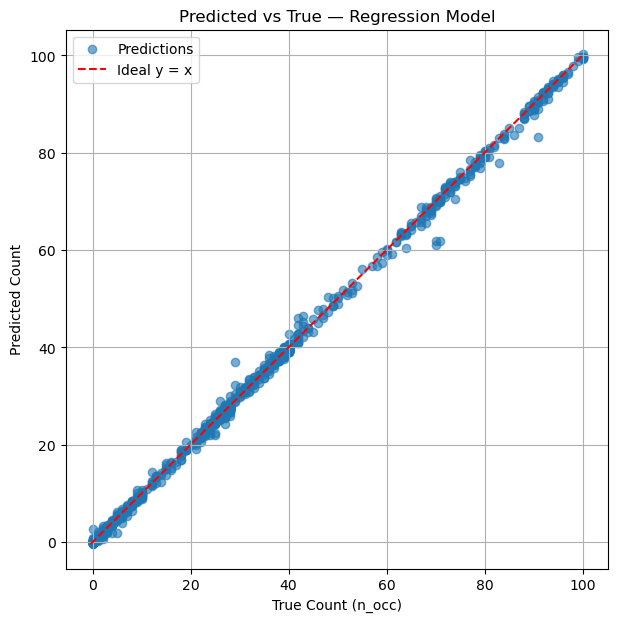

In [28]:
true_vals, pred_vals = plot_pred_vs_true(best_model, test_reg_loader, device)

#### MAE's ranges
Furthermore, since in our dataset we have different camera images corresponding to different number of cars and the majority of them is when we have zero cars, we decided to perform also an evaluation of the MAE by ranges, such that we will be able to understand if the model is able to generalize well in every kind of situation or it is biased by the number of cars in the image.

Low-occupancy ranges (0–10) show very low error, indicating that sparse scenes are easier to estimate.
Mid-range occupancies (11–40) maintain sub-unit MAE, showing stable performance.
Higher occupancies (41–100) exhibit larger MAE, which is expected due to:
increased visual clutter,
occlusions between vehicles,
higher sensitivity to small absolute counting errors.
Despite this increase, errors remain small relative to the total parking capacity, consistent with the low ROE.

In [29]:
bins = {
"0": (0, 0),
"1-10": (1, 10),
"11-20": (11, 20),
"21-30": (21, 30),
"31-40": (31, 40),
"41-60": (41, 60),
"61-100": (61, 100),
}

def mae_per_bin(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
        
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            preds = model(x)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_targets.extend(y.cpu().numpy().tolist())

    all_preds = np.array(all_preds).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)
    print("\n=== MAE for bins of n_occ ===\n")
    
    for label, (low, high) in bins.items():
        mask = (all_targets >= low) & (all_targets <= high)
        if mask.sum() == 0:
            print(f"{label}: no examples")
            continue

        mae = np.mean(np.abs(all_preds[mask] - all_targets[mask]))
        print(f"Bin {label:>5} ({low:>2} – {high:>3}) | "
              f"Example: {mask.sum():>4} | MAE = {mae:.3f}")
    return

mae_per_bin(best_model, test_reg_loader, device)


=== MAE for bins of n_occ ===

Bin     0 ( 0 –   0) | Example:  251 | MAE = 0.123
Bin  1-10 ( 1 –  10) | Example:  251 | MAE = 0.359
Bin 11-20 (11 –  20) | Example:   44 | MAE = 0.545
Bin 21-30 (21 –  30) | Example:  221 | MAE = 0.609
Bin 31-40 (31 –  40) | Example:  235 | MAE = 0.463
Bin 41-60 (41 –  60) | Example:   52 | MAE = 0.959
Bin 61-100 (61 – 100) | Example:  188 | MAE = 0.855


Finally, we repeat the same visualization performed before but now in terms of ranges, such that we will be able to see the predicted vs real values also in the ranges:

In [30]:

def plot_pred_vs_true_bins(model, test_loader, device, bins):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_targets.extend(y.cpu().numpy().tolist())

    all_preds = np.array(all_preds).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)

    n_bins = len(bins)
    n_cols = 3
    n_rows = int(np.ceil(n_bins / n_cols))

    plt.figure(figsize=(18, 5 * n_rows))

    idx = 1

    for label, (low, high) in bins.items():
        mask = (all_targets > low) & (all_targets <= high)

        if label == "0":
            continue

        plt.subplot(n_rows, n_cols, idx)
        idx += 1

        if mask.sum() == 0:
            plt.title(f"{label} — no examples")
            plt.axis("off")
            continue

        preds_bin = all_preds[mask]
        targets_bin = all_targets[mask]

        plt.scatter(targets_bin, preds_bin, alpha=0.6, label="Predictions")

        # y=x
        min_v = min(targets_bin.min(), preds_bin.min())
        max_v = max(targets_bin.max(), preds_bin.max())
        plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2)

        # MAE of the bin 
        mae_bin = np.mean(np.abs(preds_bin - targets_bin))

        plt.xlabel("True Count (n_occ)")
        plt.ylabel("Predicted")
        plt.title(f"{label}  (MAE = {mae_bin:.3f})")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


The bin specific plots show that predictions consistently remain close to the ideal $y = x$ line across all occupancy ranges, with only a slight increase in variance at higher counts. 

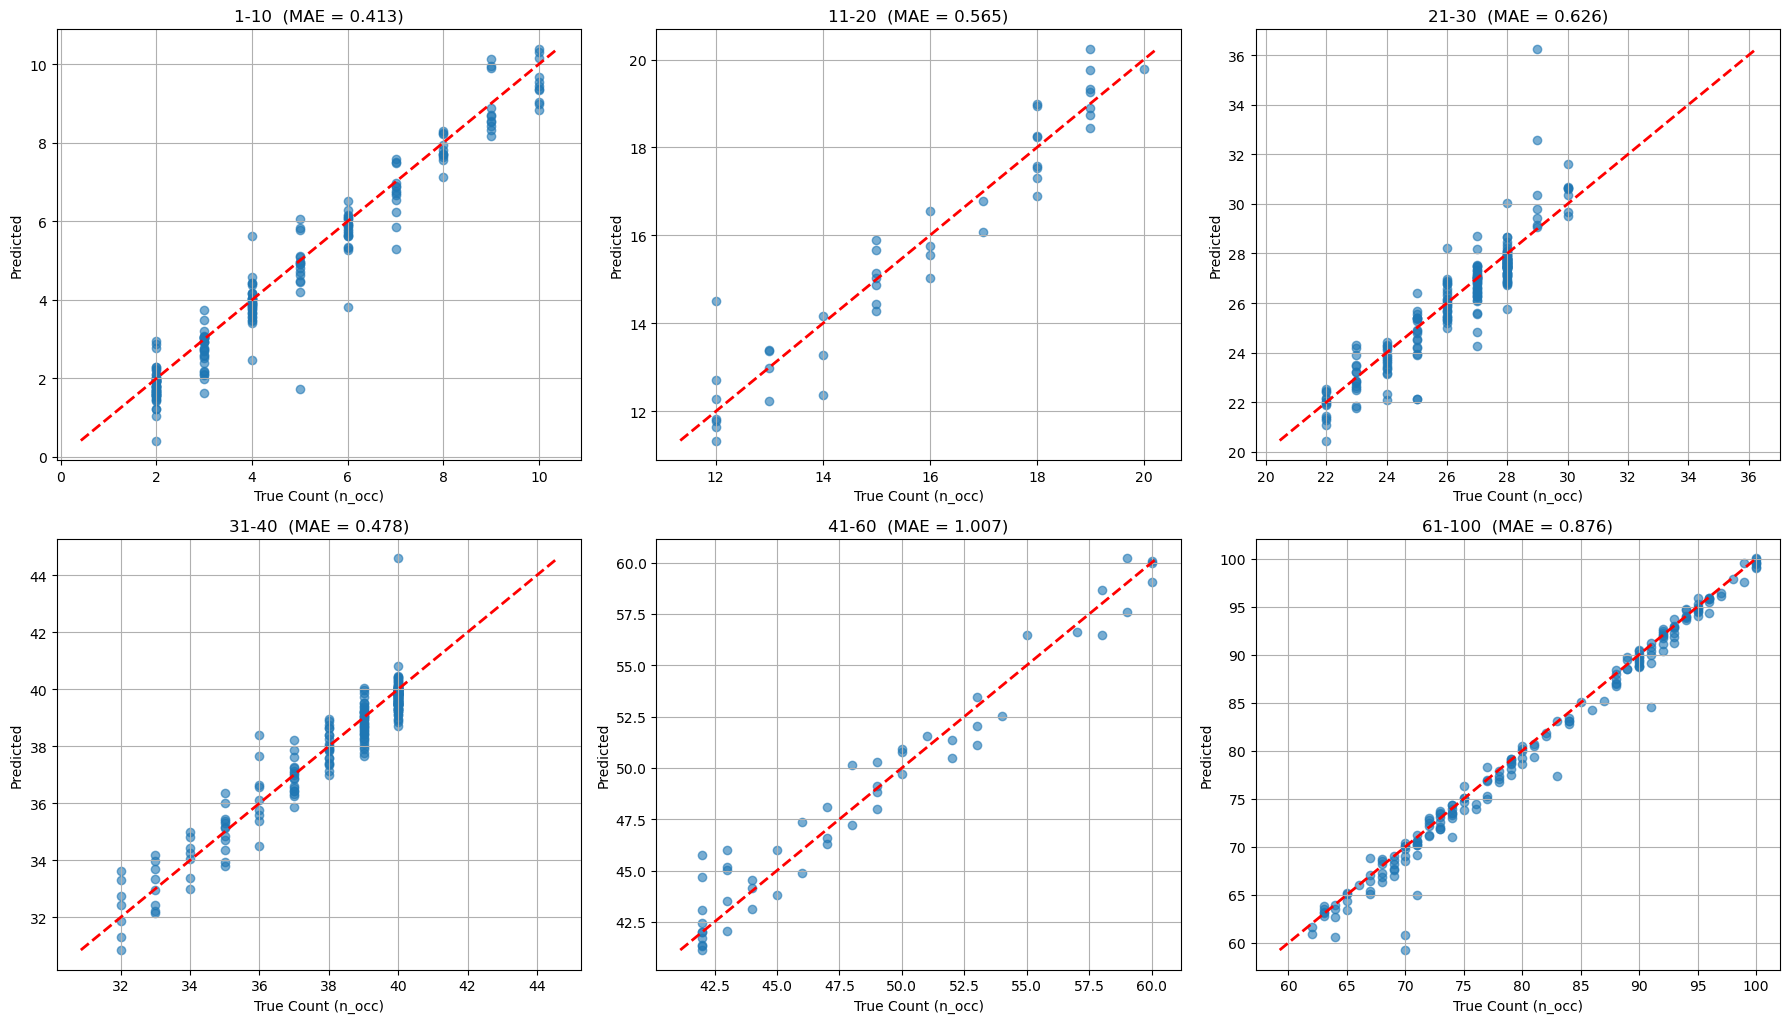

In [31]:
plot_pred_vs_true_bins(best_model, test_reg_loader, device, bins)

#### Bounding boxes and Grad-CAM

Bounding box visualizations are used exclusively for qualitative inspection and annotation sanity checking. Each bounding box represents a labeled parking slot, with different colors indicating different slot states (empty vs non-empty). These annotations are not used by the regression model at inference time; rather, they serve as a visual reference to contextualize the model’s predictions and to support interpretability analyses.

To investigate how the network estimates the number of occupied parking spots, Grad-CAM is applied to the last convolutional layer of the ResNet backbone `(layer4)`. Since the task is formulated as a regression problem, Grad-CAM is computed with respect to the scalar output of the regression head, by backpropagating a unit gradient through the output. This allows identification of the spatial regions that contribute most to the predicted count.

We use the `draw_boxes_on_image` function to visualize where the boxes are in the images, in order to give better interpretation of the implemented Grad-CAM.

In [32]:
def draw_boxes_on_image(img_original, file_name, targets):

    img_bb = img_original.copy()
    draw = ImageDraw.Draw(img_bb)

    entry = next(v for v in targets.values() if v["file_name"] == file_name)

    for ann in entry["anns"]:
        x, y, w, h = ann["bbox"]
        cat = ann["category"]

        color = "red" if cat == 2 else "green"

        draw.rectangle([x, y, x+w, y+h], outline=color, width=2)

    return img_bb

In [33]:

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        # target layer = the last layer of the backbone
        target_layer = self.model.backbone.layer4

        # hook forward to save the activations
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        # hook backward to save the gradients
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x):
        # forward
        out = self.model(x)

        # backward 
        self.model.zero_grad()
        out.backward(torch.ones_like(out))

        # mean of the gradients of the channel 
        weights = self.gradients.mean(dim=(2,3), keepdim=True)

        # weighted combination of the activations
        cam = (weights * self.activations).sum(dim=1).squeeze()

        # ReLU
        cam = F.relu(cam)

        # normalization
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), out.item()

In [34]:
def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.5, heatmap_color, 0.5, 0)
    return overlay

The resulting Grad-CAM heatmaps show a consistent and interpretable pattern. High activation regions are concentrated over areas containing rows of parked vehicles, corresponding to regions with high parking density. In contrast, background elements such as empty parking spaces, vegetation and peripheral areas receive little to no attention. This behavior indicates that the model focuses on semantically relevant visual cues, rather than being influenced by irrelevant background information.

A strong qualitative alignment is observed between the Grad-CAM activations and the spatial distribution of occupied bounding boxes. Regions with a high concentration of bounding boxes generally correspond to areas with higher Grad-CAM intensity. This suggests that, although the network is not explicitly trained for object detection, it implicitly learns a spatial representation correlated with the number of occupied parking slots.
Furthermore, the attention maps exhibit a smooth, band-shaped pattern centered in the image, which is consistent with the camera perspective and scene geometry. Most parking slots are located within a specific depth range, and the Grad-CAM activations reflect this structure rather than forming arbitrary or fragmented patterns. This supports the interpretation that the model captures meaningful geometric regularities of the parking layout.

For the inspected examples, we decided to show how the net works on an image of the train set and one of the test set. We see that in both cases the predicted counts are very close to the ground truth values (e.g. prediction = $67.005$ vs ground truth = $67$, prediction = $75.05$ vs ground truth = $75$), further reinforcing the consistency between numerical accuracy and visual explanations.

It is important to note that Grad-CAM provides qualitative interpretability, not pixel-level localization guarantees. Nevertheless, the observed correspondence between activation regions, bounding box density, and accurate predictions provides strong evidence that the regression model bases its decisions on relevant visual information and does not rely on spurious correlations.

Grad-CAM on the train set:

Net prediction: 67.00504302978516
Real Value: 67


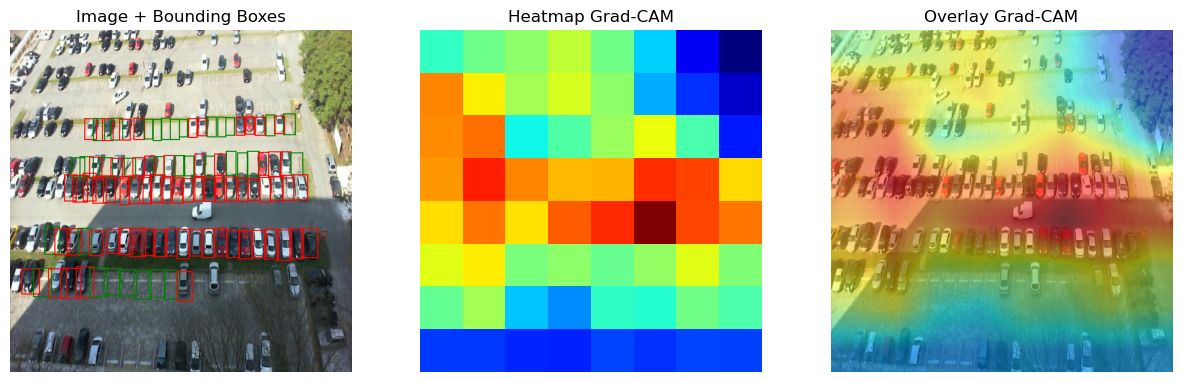

In [35]:
img_path = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/train/2012-09-11_15_16_58_jpg.rf.61d961a86c9a16694403dfcb72cd450c.jpg"
file_name = os.path.basename(img_path)

img_original = Image.open(img_path).convert("RGB")
img_with_boxes = draw_boxes_on_image(img_original, file_name, train_targets)

img_tensor = transform(img_original).unsqueeze(0).to(device)

# GradCAM
cam_gen = GradCAM(best_model)
heatmap, pred_value = cam_gen.generate(img_tensor)

print("Net prediction:", pred_value)

real_value = next(
    v["n_occ"] for v in train_targets.values()
    if v["file_name"] == file_name
)

print("Real Value:", real_value)

# Convert PIL -> OpenCV
img_np = np.array(img_original)
img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Overlay
overlay = overlay_heatmap(img_np_bgr, heatmap)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_with_boxes)
plt.title("Image + Bounding Boxes")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Heatmap Grad-CAM")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay Grad-CAM")
plt.axis("off")

plt.show()

Grad-CAM on the test set

Net prediction: 75.04856872558594
Real value: 75


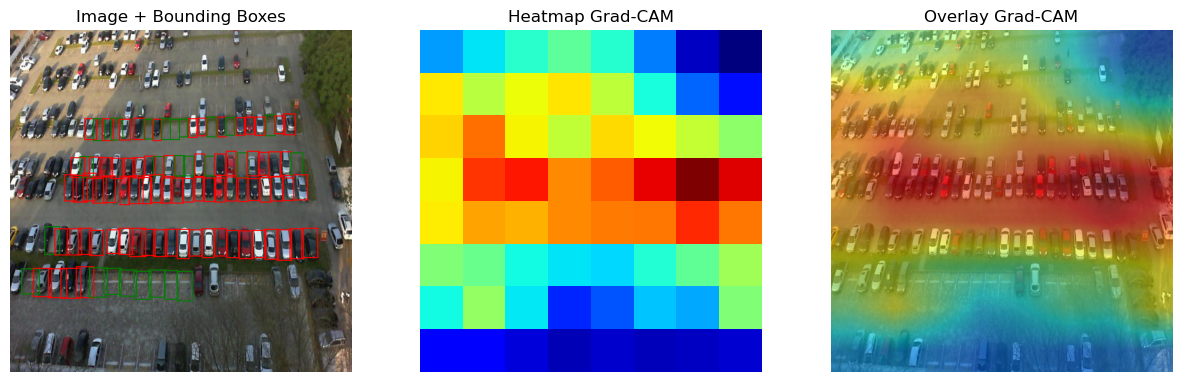

In [36]:
img_path = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/test/2012-09-11_16_48_36_jpg.rf.4ecc8c87c61680ccc73edc218a2c8d7d.jpg"
file_name = os.path.basename(img_path)

img_original = Image.open(img_path).convert("RGB")
img_with_boxes = draw_boxes_on_image(img_original, file_name, test_targets)

img_tensor = transform(img_original).unsqueeze(0).to(device)

# GradCAM
cam_gen = GradCAM(best_model)
heatmap, pred_value = cam_gen.generate(img_tensor)

print("Net prediction:", pred_value)

real_value = next(
    v["n_occ"] for v in test_targets.values()
    if v["file_name"] == file_name
)

print("Real value:", real_value)


# Convert PIL → OpenCV
img_np = np.array(img_original)
img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Overlay
overlay = overlay_heatmap(img_np_bgr, heatmap)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_with_boxes)
plt.title("Image + Bounding Boxes")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Heatmap Grad-CAM")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay Grad-CAM")
plt.axis("off")

plt.show()


## Classification

Alongside the regression model, as we anticipated in the **project overview**, a binary classification task is introduced to determine whether a parking lot is free or occupied. Each image is labeled according to an occupancy threshold of 50%.

Furthermore, the classification datasets and corresponding `DataLoaders` are instantiated following the same procedure adopted for the regression task, ensuring consistency in data preprocessing.

In [37]:
train_cls_dataset = ParkingClassificationDataset(train_images_root,train_targets,transform)
val_cls_dataset = ParkingClassificationDataset(val_images_root,val_targets,transform)

train_cls_loader = DataLoader(train_cls_dataset,batch_size=32,shuffle=True,num_workers=0)
val_cls_loader = DataLoader(val_cls_dataset,batch_size=32,shuffle=False,num_workers=0)

test_cls_dataset = ParkingClassificationDataset(test_images_root, test_targets, transform)
test_cls_loader = DataLoader(test_cls_dataset,batch_size=32, shuffle=False, num_workers=0)

## Training Loop: Classification

The classification model is trained by reusing the backbone learned during the regression task, while replacing and reinitializing the final head for binary classification. All backbone parameters are frozen and only the classification head is optimized. This design enforces that the classifier relies exclusively on the visual features already learned for occupancy estimation.

Training is performed using Binary Cross-Entropy with logits, optimized via Adam and a cosine annealing learning rate schedule, starting from a learning rate of $10^{-3}$ without warm up epochs, in constrast to what we did in the regression task: although learning rate warm up is commonly used to stabilize early training, in our setting it introduced additional variability in the loss curves. Empirical evidence showed that removing the warm up resulted in smoother and more stable convergence, suggesting that warm up was unnecessary given the already stable optimization regime. 

Early stopping is applied based on validation accuracy to prevent overfitting.

In [49]:
def train_classification(model, train_loader, val_loader, device,
                         epochs=30, lr=1e-4, patience=8,
                         save_dir="checkpoints", save_name="best_cls_model.pth"):
    
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, save_name)


    # ------------------------------------------------------
    #  INIT MODEL + WEIGHTS
    # ------------------------------------------------------
    model.to(device)
    opt = torch.optim.Adam(model.head.parameters(), lr=1e-4)

    # Scheduler Cosine Annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    train_losses = []
    val_losses = []
    
    # metrics for confusion matrix 
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    # for early stopping
    best_accuracy = float("-inf")
    patience_counter = 0

    animator = Animator(
        xlabel='epoch',
        ylabel='loss',
        xlim=[1, epochs],
        legend=['train', 'val']
    )

    print("Starting training...")
    for epoch in range(1, epochs+1):

        # -------------------------
        # TRAIN MODE
        # -------------------------
        model.train()
        train_loss = 0.0
        n = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            logits = model(x)                    
            loss = classification_loss(logits, y)
            loss.backward()
            opt.step()

            train_loss += loss.item() * x.size(0)
            n += x.size(0)

        train_loss /= n
        train_losses.append(train_loss)

        # -------------------------
        # VALIDATION MODE
        # -------------------------
        model.eval()
        val_loss = 0.0
        m = 0

        total_correct = 0
        tp = fp = fn = tn = 0
        
        with torch.no_grad():
            
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                logits = model(x)
                loss = classification_loss(logits, y)

                val_loss += loss.item() * x.size(0)
                m += x.size(0)

                # predictions
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()

                total_correct += (preds == y).sum().item()

                tp += ((preds == 1) & (y == 1)).sum().item()
                fp += ((preds == 1) & (y == 0)).sum().item()
                fn += ((preds == 0) & (y == 1)).sum().item()
                tn += ((preds == 0) & (y == 0)).sum().item()

        val_loss /= m
        val_losses.append(val_loss)

        # =====================
        #  METRICS CALCULATION
        # =====================
        accuracy = total_correct / m
        precision = tp / (tp + fp + 1e-8)
        recall    = tp / (tp + fn + 1e-8)
        f1        = 2 * precision * recall / (precision + recall + 1e-8)

        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1s.append(f1)

        # -------------------------
        # UPDATE SCHEDULER
        # -------------------------
        scheduler.step()

        # -------------------------
        # UPDATE ANIMATOR
        # -------------------------
        animator.add(epoch, [train_loss, val_loss])

        print(f"[CLS] Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Acc: {accuracy:.4f} | "
              f"Prec: {precision:.4f} | "
              f"Recall: {recall:.4f} | "
              f"F1: {f1:.4f}")
        
        # -------------------------
        # EARLY STOPPING + BEST MODEL SAVE
        # -------------------------
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0

            torch.save(model.state_dict(), save_path)
            print(f"Saved new BEST model at: {save_path}")

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

    print(f"\nBest model saved at: {save_path} | Best Accuracy = {best_accuracy:.4f}")


    return (
        model,
        train_losses,
        val_losses,
        val_accuracies,
        val_precisions,
        val_recalls,
        val_f1s
    )

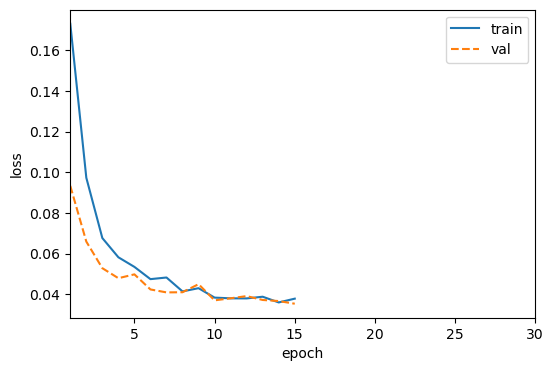

[CLS] Epoch 15/30 | Train Loss: 0.0379 | Val Loss: 0.0354 | Acc: 0.9863 | Prec: 0.9877 | Recall: 0.9862 | F1: 0.9869
Early stopping triggered at epoch 15.

Best model saved at: checkpoints/best_cls_model.pth | Best Accuracy = 0.9875


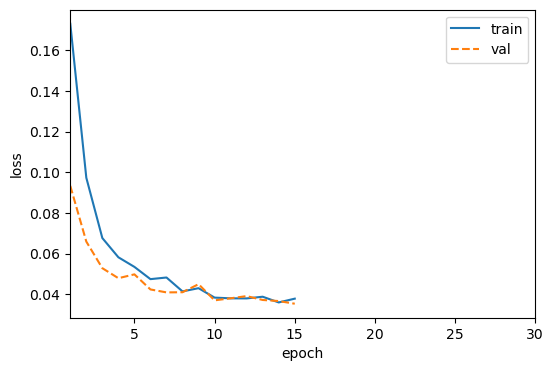

In [50]:
cls_model = ResNetClassification(
    trained_backbone = best_model.backbone    
)

# we initialize only the head weights
cls_model.head.apply(init_weights)

for p in cls_model.backbone.parameters():
    p.requires_grad = False # this doesn't allow to update the backbone weights during training

trained_cls_model = train_classification(
    cls_model,
    train_cls_loader,
    val_cls_loader,
    device,
    epochs=30,
    lr=1e-3, 
    patience=8,
    save_dir="checkpoints", 
    save_name="best_cls_model.pth"
)

The training and validation loss curves show a smooth and stable convergence, with no signs of divergence or overfitting. The validation loss remains slightly lower than the training loss throughout training, which is expected when using BCE: the loss penalizes prediction confidence rather than misclassification alone, meaning that even correct but less confident predictions contribute to a non-zero loss.
Early stopping is triggered at epoch $15$, and the best model, selected accordingly to the accuracy value, achieves $Accuracy = 0.9875$

While the last iteration reaches 
- $Precision = 0.9877$
- $Recall = 0.9862$
- $F1-score = 0.9869$

These results indicate that the classification model is highly effective at distinguishing between free and mostly occupied parking. The strong performance confirms that the features learned during regression are also well suited for the derived binary decision task and that freezing the backbone does not limit classification performance.

Overall, the classification results are consistent with the regression analysis and demonstrate that a continuous occupancy estimation can be reliably transformed into a discrete availability decision.

In [51]:
best_cl_model = ResNetClassification(trained_backbone = best_model.backbone)
best_cl_model = load_model(best_cl_model, "Checkpoints/best_cls_model.pth", device)
best_cl_model

Model loaded from: Checkpoints/best_cls_model.pth


ResNetClassification(
  (backbone): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxp): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

## Test Phase Evaluation: Classification
The trained classification model is evaluated on the held-out test set using Binary Cross-Entropy loss, accuracy, precision, recall, F1-score, confusion matrix and ROC–AUC.

In [52]:
def test_classification(model, test_loader, device):
    model.eval()

    total_loss = 0.0
    n = 0

    total_correct = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)  

            logits = model(x)
            loss = F.binary_cross_entropy_with_logits(logits, y.float(), reduction="sum")

            total_loss += loss.item()
            n += x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

            total_correct += (preds == y).sum().item()

            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            true_negatives += ((preds == 0) & (y == 0)).sum().item()

            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu())

    # --------------------------
    # FINAL METRICS
    # --------------------------

    avg_loss = total_loss / n
    accuracy = total_correct / n

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall    = true_positives / (true_positives + false_negatives + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    # --------------------------
    # CONFUSION MATRIX
    # --------------------------

    CM = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])

    plt.figure(figsize=(6, 5))
    plt.imshow(CM, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Pred 0', 'Pred 1'])
    plt.yticks(tick_marks, ['True 0', 'True 1'])

    thresh = CM.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(CM[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if CM[i, j] > thresh else "black",
                     fontsize=12)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

    # ============================
    #   NO INFORMATION RATE (NIR)
    # ============================

    # reconstruct y_true
    y_true = torch.cat(all_labels).numpy().astype(int)

    counts = np.bincount(y_true)
    nir = counts.max() / counts.sum()


    # --------------------------
    # OUTPUT
    # --------------------------

    print("\n[CLASSIFICATION TEST RESULTS]")
    print(f"Loss BCE:   {avg_loss:.4f}")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print("NIR:        {:.4f}".format(nir))
    print("\nConfusion Matrix:\n", CM)

    return avg_loss, accuracy, precision, recall, f1, CM, nir, all_labels, all_probs

#### Evaluation metrics
The model achieves:
- $Accuracy = 0.9879$
- $Precision = 0.9847$
- $Recall = 0.9923$
- $F1-score = 0.9885$
- $BCE loss = 0.0330$

These values indicate a highly reliable binary decision performance, with balanced precision and recall, confirming that both false positives and false negatives are rare. Confusion Matrix analysis shows that misclassifications are very limited and well balanced across the two classes. This symmetry indicates that the model does not exhibit a strong bias toward either predicting free or occupied.

The No Information Rate (NIR) is approximately $0.52$, corresponding to the accuracy of a naive classifier that always predicts the majority class.
The achieved test accuracy ($0.9879$) is therefore substantially higher than the NIR, confirming that the classifier learns meaningful patterns and does not rely on class imbalance.

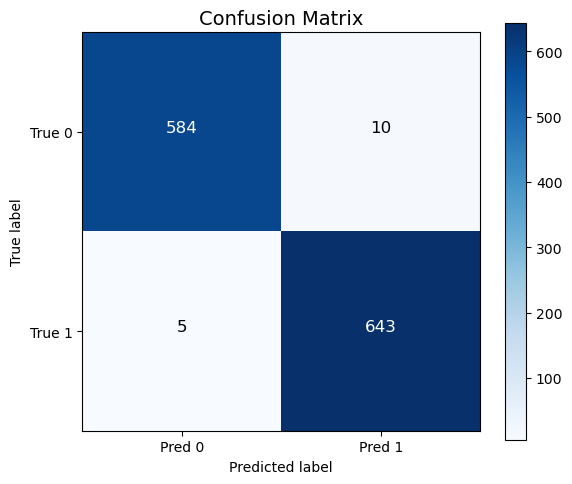


[CLASSIFICATION TEST RESULTS]
Loss BCE:   0.0330
Accuracy:   0.9879
Precision:  0.9847
Recall:     0.9923
F1-score:   0.9885
NIR:        0.5217

Confusion Matrix:
 [[584  10]
 [  5 643]]


In [53]:
avg_loss, accuracy, precision, recall, f1, CM, nir, all_labels, all_probs = test_classification(
    best_cl_model,
    test_cls_loader ,
    device
)

#### ROC Curve
The ROC curve is sharply concentrated near the top-left corner, with an $AUC = 0.9996$.
This indicates an excellent separation between the two classes across all possible decision thresholds, and shows that the model’s output probabilities are highly discriminative.
Importantly, this result demonstrates that the strong performance is not tied to the fixed 0.5 threshold, but remains robust across a wide range of thresholds.

In [54]:

def plot_roc_curve(all_labels, all_probs):
    """
    Plots a standard ROC curve.

    Parameters
    ----------
    all_labels : array-like
        Ground-truth binary labels (0 or 1).
    all_probs : array-like
        Predicted probabilities in the range [0, 1].

    Returns
    -------
    auc_value : float
        The Area Under the ROC Curve (AUC).
    """

    # Convert inputs to numpy arrays
    y_true = np.asarray(all_labels, dtype=int)
    y_score = np.asarray(all_probs, dtype=float)

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_value = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="indigo", linewidth=2, label=f"AUC = {auc_value:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Baseline")

    plt.title("ROC Curve", fontsize=16)
    plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
    plt.ylabel("True Positive Rate (Recall)", fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

    return auc_value


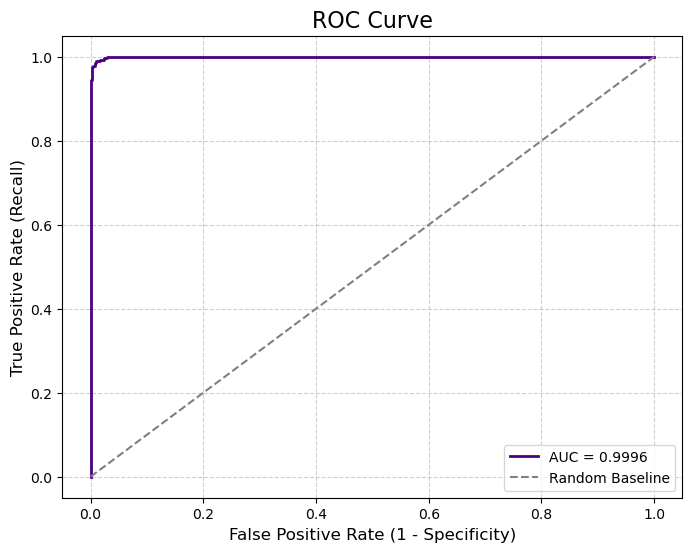

AUC: 0.9995921145612503


In [55]:
labels = torch.cat(all_labels).numpy()
probs = torch.cat(all_probs).numpy()
auc_value = plot_roc_curve(labels, probs)
print("AUC:", auc_value)

#### Ablation-CAM

For the classification task, standard Grad-CAM and score-based CAM were initially applied to visualize model attention. However, the resulting heatmaps were unstable and poorly aligned with semantically meaningful regions. This behavior is due to the classifier being extremely confident in its predictions, which causes gradient saturation (bringing values near 0) and reduces the usefulness of gradient-based explanation methods.

To address this limitation, Ablation-CAM was employed, according to the findings of the paper of Desai & Ramaswamy (2020). Unlike Grad-CAM, Ablation-CAM estimates channel importance by measuring the drop in the model’s output for the target class when individual feature-map channels are removed. This produces a causal measure of importance that does not rely on gradients and is therefore robust to saturation effects.

The resulting heatmaps exhibit clear and interpretable patterns. High activation regions correspond to areas with dense clusters of parked vehicles, while background regions and empty spaces contribute minimally to the prediction. This indicates that the classifier bases its decision on global vehicle density and spatial layout, rather than on isolated objects or local textures.

In [56]:
class AblationCAM:
    def __init__(self, model, target_layer=None):
        self.model = model.eval()
        self.device = next(model.parameters()).device

        if target_layer is None:
            target_layer = model.backbone.layer4
        
        self.activations = None

        def hook(module, inp, out):
            self.activations = out.detach()

        target_layer.register_forward_hook(hook)
        self.target_layer = target_layer

    def generate(self, x):
        """
        Ablation CAM:
        1. forward pass to obtain feature maps
        2. ablate (set to zero) each channel individually
        3. measure the drop in the logit
        4. weights = confidence drop
        5. weighted linear combination
        """
        # forward 
        logits = self.model(x)
        orig_logit = logits.squeeze().item()

        A = self.activations               # [1,C,H,W]
        _, C, H, W = A.shape

        A_np = A.squeeze(0).cpu().numpy()

        scores = []

        # for each channel → ablation test
        for k in range(C):
            A_mod = A.clone()
            A_mod[0, k] = 0  # ablation

            def forward_override(module, inp, out):
                return A_mod

            handle = self.target_layer.register_forward_hook(forward_override)

            with torch.no_grad():
                out = self.model(x).squeeze().item()

            handle.remove()

            drop = max(orig_logit - out, 0)
            scores.append(drop)

        scores = np.array(scores)

        # weighted combination
        heatmap = np.dot(scores, A_np.reshape(C, -1)).reshape(H, W)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-6)

        return heatmap, orig_logit



def overlay_heatmap_cl(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.5, heatmap_color, 0.5, 0)
    return overlay

Logit: 5.717625617980957
Predizione rete: 0.9967232346534729
Valore reale: 0.9642857142857143


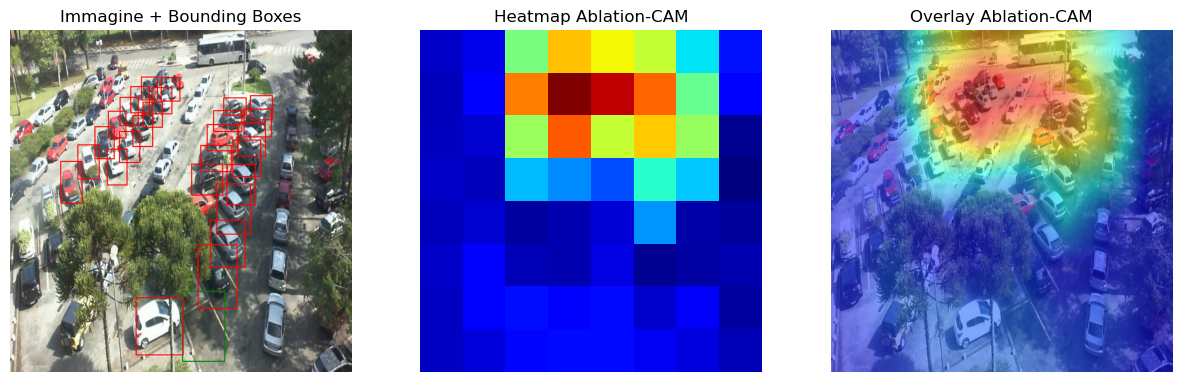

In [57]:
img_path = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/PKLot/test/2012-12-18_10_50_06_jpg.rf.38c5b07c90fbf8e7090cb8b5f13a1e3e.jpg"
file_name = os.path.basename(img_path)

img_original = Image.open(img_path).convert("RGB")
img_with_boxes = draw_boxes_on_image(img_original, file_name, test_targets)

img_tensor = transform(img_original).unsqueeze(0).to(device)

# ----------------------------------------------------------
# ABLATION CAM
# ----------------------------------------------------------
cam_gen = AblationCAM(best_cl_model)
heatmap, pred_value = cam_gen.generate(img_tensor)

logit = pred_value
perc = torch.sigmoid(torch.tensor(logit)).item()

print("Logit:", logit)
print("Predizione rete:",  perc)

real_value = next(
    v["ratio_occ"] for v in test_targets.values()
    if v["file_name"] == file_name
)

print("Valore reale:", real_value)

# Convert PIL → OpenCV
img_np = np.array(img_original)
img_np_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

overlay = overlay_heatmap_cl(img_np_bgr, heatmap)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_with_boxes)
plt.title("Immagine + Bounding Boxes")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Heatmap Ablation-CAM")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay Ablation-CAM")
plt.axis("off")

plt.show()

## References

- A Theoretical Framework for Back-Propagation (Lecun, 1988)
- PyTorch documentation: https://docs.pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter
- Deep Residual Learning for Image Recognition (He, 2015)
- Cyclical Learning Rates for Training Neural Networks (Leslie Smith, 2015)
- Ablation-cam: Visual explanations for deep convolutional network via gradient-free localization (Desai & Ramaswamy, 2020)